# Extract text from images using Azure OpenAI GPT-4o

This notebook contains code and examples showing how to extract text information from images using the Azure OpenAI GPT-4o model. You can specify the information or questions you want to extract, and the model can return the results in a structured format such as JSON.

Here is the image we are extracting text from. It is the summary of the 2024 Work Trend Index Annual Report from Microsoft and LinkedIn. See full report at: https://www.microsoft.com/en-us/worklab/work-trend-index/ai-at-work-is-here-now-comes-the-hard-part

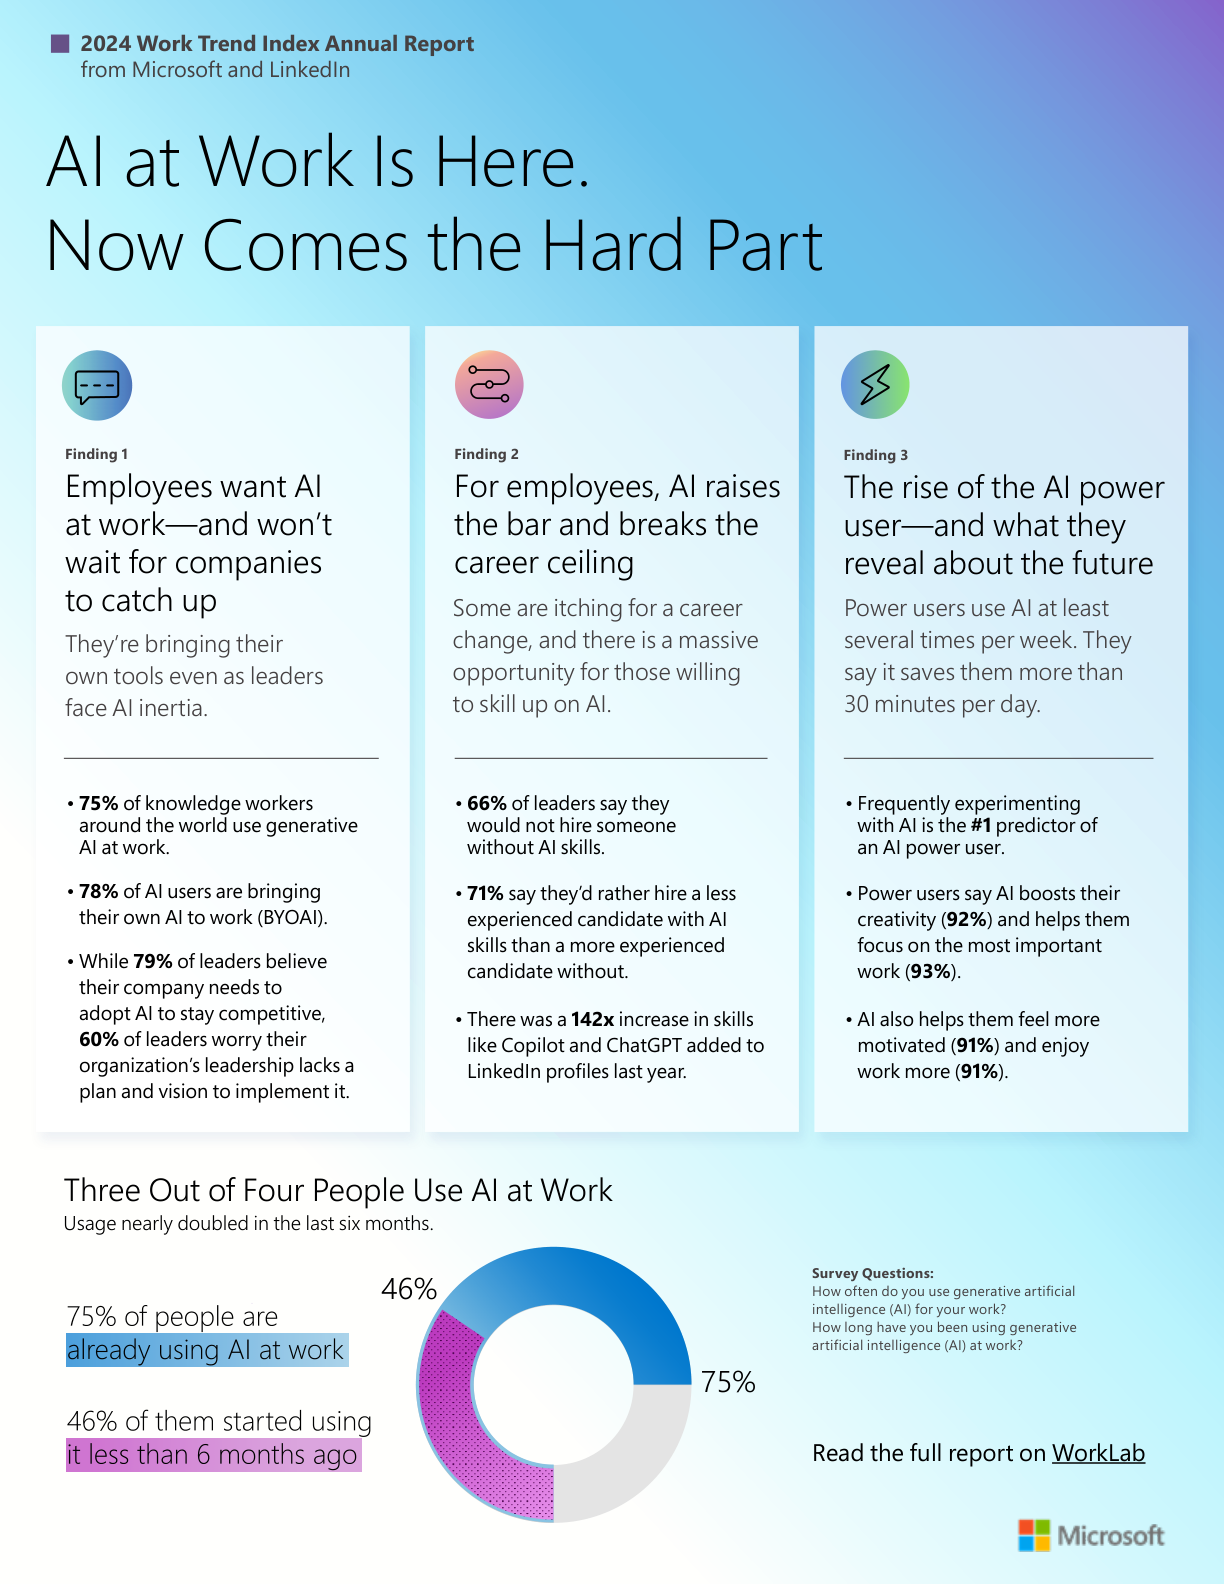

In [25]:
from IPython.display import Image, display
display(Image('2024_Work_Trend_Index_Annual_Report.png', width=600))

#### Settings

In [17]:
import base64
import os
from dotenv import load_dotenv
from mimetypes import guess_type
from openai import AzureOpenAI
from pydantic import BaseModel

load_dotenv()

True

In [2]:
# Azure OpenAI environment variables
aoai_endpoint = os.getenv("AOAI_ENDPOINT")
aoai_api_key = os.getenv("AOAI_API_KEY")
aoai_deployment_name = os.getenv("AOAI_DEPLOYMENT")

# Set the path to the image file
image_path = "2024_Work_Trend_Index_Annual_Report.png"

In [3]:
# Initialize the AzureOpenAI client  
client = AzureOpenAI(  
    azure_endpoint=aoai_endpoint,  
    api_key=aoai_api_key, 
    api_version="2024-08-01-preview"  
)  

#### Functions

In [4]:
def local_image_to_data_url(image_path):
    """
    Convert a local image file to a data URL.

    Parameters:
    -----------
    image_path : str
        The path to the local image file to be converted.

    Returns:
    --------
    str
        A data URL representing the image, suitable for embedding in HTML or other web contexts.
    """
    # Get mime type
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = 'application/octet-stream'

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(
            image_file.read()).decode('utf-8')

    return f"data:{mime_type};base64,{base64_encoded_data}"



In [21]:
def call_azure_openai(prompt, image_data_url, client=client, aoai_deployment_name=aoai_deployment_name, response_format=None):
    """
    Call the Azure OpenAI service to analyze an image.

    """

    if response_format is None:
        response = client.chat.completions.create(
            model=aoai_deployment_name,
            messages=[{
                "role": "system", 
                "content": "You are an AI helpful assistant."
            }, {
                "role": "user",
                "content": [{
                    "type": "text",
                    "text": prompt
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": image_data_url
                    }
                }]
            }],
            max_tokens=4000,
            temperature=0.7)
    else:
        response =client.beta.chat.completions.parse(
            model=aoai_deployment_name,
            messages=[{
                "role": "system", 
                "content": "You are an AI helpful assistant."
            }, {
                "role": "user",
                "content": [{
                    "type": "text",
                    "text": prompt
                }, {
                    "type": "image_url",
                    "image_url": {
                        "url": image_data_url
                    }
                }]
            }],
            max_tokens=4000,
            temperature=0.7,
            response_format=response_format)

    # Print result
    print("Azure OpenAI Response:")
    print(response.choices[0].message.content)

In [6]:
# data url
image_data_url = local_image_to_data_url(image_path)

#### Test 1 - Describe image

In [13]:
prompt = "Describe this image:"

call_azure_openai(prompt, image_data_url)

Azure OpenAI Response:
The image is an infographic from the "2024 Work Trend Index Annual Report" by Microsoft and LinkedIn. It discusses the integration of AI in the workplace and includes three main findings:

1. **Finding 1**: Employees want AI at work and aren't waiting for companies to catch up. 
   - 75% of knowledge workers use generative AI.
   - 78% of AI users bring their own AI tools.
   - 79% of leaders believe AI adoption is needed for competitiveness, but 60% are concerned about leadership's lack of planning.

2. **Finding 2**: AI raises the bar and breaks the career ceiling for employees.
   - 66% of leaders wouldn't hire someone without AI skills.
   - 71% prefer less experienced candidates with AI skills over more experienced ones without.
   - There was a 142% increase in skills like Copilot and ChatGPT on LinkedIn profiles.

3. **Finding 3**: The rise of the AI power user.
   - Frequent AI experimentation is key for power users.
   - AI boosts creativity (92%) and he

#### Test 2 - Extract text from image

In [14]:
prompt = "Extract the text from this image:"

call_azure_openai(prompt, image_data_url)

Azure OpenAI Response:
Sure, here is the text extracted from the image:

---

2024 Work Trend Index Annual Report  
from Microsoft and LinkedIn

AI at Work Is Here.  
Now Comes the Hard Part

Finding 1  
Employees want AI at work—and won’t wait for companies to catch up  
They’re bringing their own tools even as leaders face AI inertia.

- 75% of knowledge workers around the world use generative AI at work.
- 78% of AI users are bringing their own AI to work (BYOAI).
- While 79% of leaders believe their company needs to adopt AI to stay competitive, 60% of leaders worry their organization’s leadership lacks a plan and vision to implement it.

Finding 2  
For employees, AI raises the bar and breaks the career ceiling  
Some are itching for a career change, and there is a massive opportunity for those willing to skill up on AI.

- 66% of leaders say they would not hire someone without AI skills.
- 71% say they’d rather hire a less experienced candidate with AI skills than a more experien

#### Test 3 - Answer question from image text

In [15]:
prompt = "Based on this image, what percentage of knowledge workers around the world use generative AI at work?"

call_azure_openai(prompt, image_data_url)

Azure OpenAI Response:
According to the image, 75% of knowledge workers around the world use generative AI at work.


#### Test 4 - Extract specific information with structured output

In [22]:
prompt = """Based on this image, answer the questions: 
            1) what percentage of knowledge workers around the world use generative AI at work? 
            2) what percentage of leaders believe their company needs to adopt AI to stay competitive?"""

# Define output format
class ExtractedAnswers(BaseModel):
    PctWorkersAI: int
    PctLeadersAI: int

call_azure_openai(prompt, image_data_url, response_format=ExtractedAnswers)

Azure OpenAI Response:
{"PctWorkersAI":75,"PctLeadersAI":79}
